<a href="https://colab.research.google.com/github/muajnstu/Multi-Class-Classification-of-YouTube-Videos-Using-A-BERT-enhanced-Machine-Learning-approach/blob/main/BERT_multi_class_text_classification_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nlpaug
!pip install ktrain
!pip install tensorflow
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 52.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 49.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 34.8 MB/s eta 0:00:00
  Created wheel for ktrain: filename=ktrain-0.41.4-py3-none-any.whl size=25316931 sha256=b3dda0e3b194cb46a76ca0b669222f58120e0611287049f2621b597106bc2f7d
  Stored in directory: /root/.cache/pip/wheels/a6/b9/88/364e4ea6461e9f1feee834bfc2f15b92edc62600e08e3d3f5f
  Cre

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, TFBertForSequenceClassification

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/muajnstu/ML-Datasets/refs/heads/main/Youtube%20Video%20Dataset.csv')

#category mapping
category_map = {
    "travel blog": 0,
    "science&technology": 1,
    "food": 2,
    "art&music": 3,
    "manufacturing": 4,
    "history": 5
}
df["Category"] = df["Category"].str.lower().str.strip().map(category_map)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Combine Title and Description into one text field
df['processed_text'] = df['Title'].astype(str) + " " + df['Description'].astype(str)

# Extract meaningful part using regex
def extract_txt(text):
    match = re.search(r"(?<=\s\-\s).*", str(text))
    return match.group(0) if match else text

df['processed_text'] = df['processed_text'].apply(extract_txt)

# Basic text cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['processed_text'] = df['processed_text'].apply(clean_text)

# Rename for simplicity
df.rename(columns={'processed_text': 'text'}, inplace=True)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    df['text'], df['Category'], test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Batch tokenization
def encode_texts(tokenizer, texts, max_length=256):
    encodings = tokenizer(
        list(texts),
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    return encodings['input_ids'], encodings['attention_mask']

# Tokenize each split
train_input_ids, train_attention_masks = encode_texts(tokenizer, X_train)
val_input_ids, val_attention_masks = encode_texts(tokenizer, X_val)
test_input_ids, test_attention_masks = encode_texts(tokenizer, X_test)

# Convert labels to tensors
y_train = tf.convert_to_tensor(y_train.values, dtype=tf.int32)
y_val = tf.convert_to_tensor(y_val.values, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test.values, dtype=tf.int32)

# Model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

# Model compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model training with validation data
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train,
    batch_size=16,
    validation_data=([val_input_ids, val_attention_masks], y_val),
    epochs=5,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([test_input_ids, test_attention_masks], y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Advanced evaluation: classification report and confusion matrix
y_pred_logits = model.predict([test_input_ids, test_attention_masks]).logits
y_pred = np.argmax(y_pred_logits, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=list(category_map.keys())))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optionally: Save the trained model and tokenizer
model.save_pretrained('bert_youtube_classifier')
tokenizer.save_pretrained('bert_youtube_classifier')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
561/561 [==============================] - 580s 942ms/step - loss: 0.6788 - accuracy: 0.7846 - val_loss: 0.4305 - val_accuracy: 0.8644
Epoch 2/5
561/561 [==============================] - 525s 936ms/step - loss: 0.3453 - accuracy: 0.8905 - val_loss: 0.3978 - val_accuracy: 0.8769
Epoch 3/5
561/561 [==============================] - 525s 936ms/step - loss: 0.2599 - accuracy: 0.9226 - val_loss: 0.4216 - val_accuracy: 0.8707
Epoch 4/5
561/561 [==============================] - 525s 936ms/step - loss: 0.2204 - accuracy: 0.9347 - val_loss: 0.4355 - val_accuracy: 0.8787
Epoch 5/5
36/36 [==============================] - 21s 585ms/step - loss: 0.3906 - accuracy: 0.8770
Test Loss: 0.3905840516090393
Test Accuracy: 0.8770053386688232
36/36 [==============================] - 24s 593ms/step

Classification Report:
                    precision    recall  f1-score   support

       travel blog       0.88      0.80      0.84       204
science&technology       0.77      0.95      0.85      

('bert_youtube_classifier/tokenizer_config.json',
 'bert_youtube_classifier/special_tokens_map.json',
 'bert_youtube_classifier/vocab.txt',
 'bert_youtube_classifier/added_tokens.json')

#ROC Curve

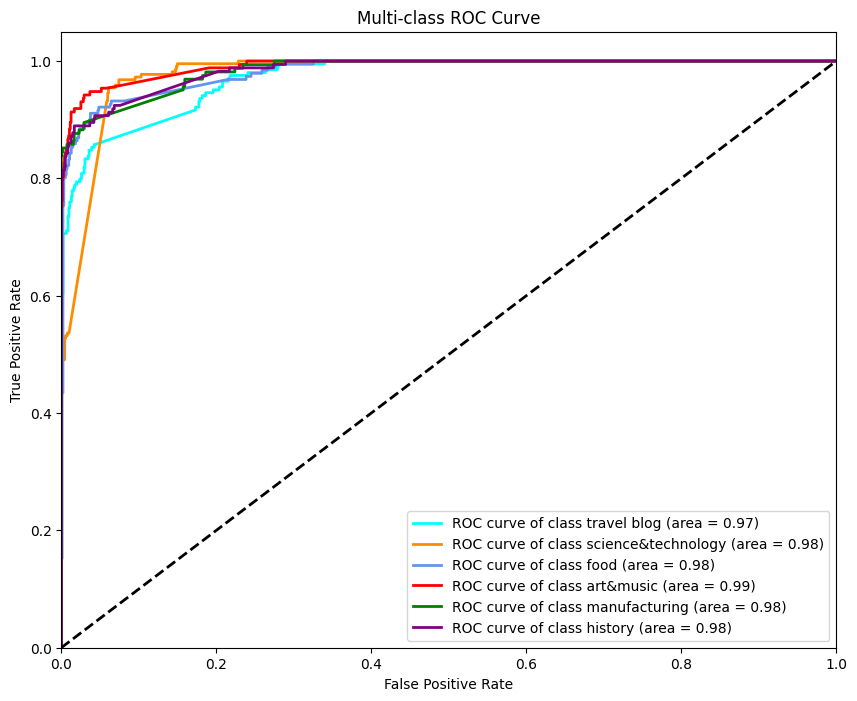

In [3]:
# 1. Binarize the labels for multi-class ROC
y_test_np = y_test.numpy() if hasattr(y_test, 'numpy') else y_test
n_classes = len(category_map)
y_test_bin = label_binarize(y_test_np, classes=list(range(n_classes)))

# 2. Get softmax probabilities for each class
y_pred_proba = tf.nn.softmax(y_pred_logits, axis=1).numpy()

# 3. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=2,
        label='ROC curve of class {0} (area = {1:0.2f})'
        ''.format(list(category_map.keys())[i], roc_auc[i])
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()